# 2. Sex, Race, and Occupation

We are interested in whether or not different sexes and/or races choose different occupations. We will first look at sex.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
import shelve
import os
import scipy.stats as stats
from itertools import combinations
plt.style.use('seaborn-dark')
plt.rcParams['figure.figsize'] = (20, 12)

In [2]:
clean_adult = pd.read_hdf('results/df1.h5', 'clean_adult/')
clean_adult.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
1,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
2,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K
3,34,Private,216864,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,0,3770,45,United-States,<=50K
4,38,Private,150601,10th,6,Separated,Adm-clerical,Unmarried,White,Male,0,3770,40,United-States,<=50K


In [3]:
female = clean_adult[clean_adult["sex"] == "Female"]
male = clean_adult[clean_adult["sex"] == "Male"]

In [4]:
male["occupation"].value_counts().sort_index()

Adm-clerical         1209
Armed-Forces            9
Craft-repair         3814
Exec-managerial      2849
Farming-fishing       924
Handlers-cleaners    1186
Machine-op-inspct    1423
Other-service        1454
Priv-house-serv         8
Prof-specialty       2547
Protective-serv       568
Sales                2336
Tech-support          571
Transport-moving     1482
Name: occupation, dtype: int64

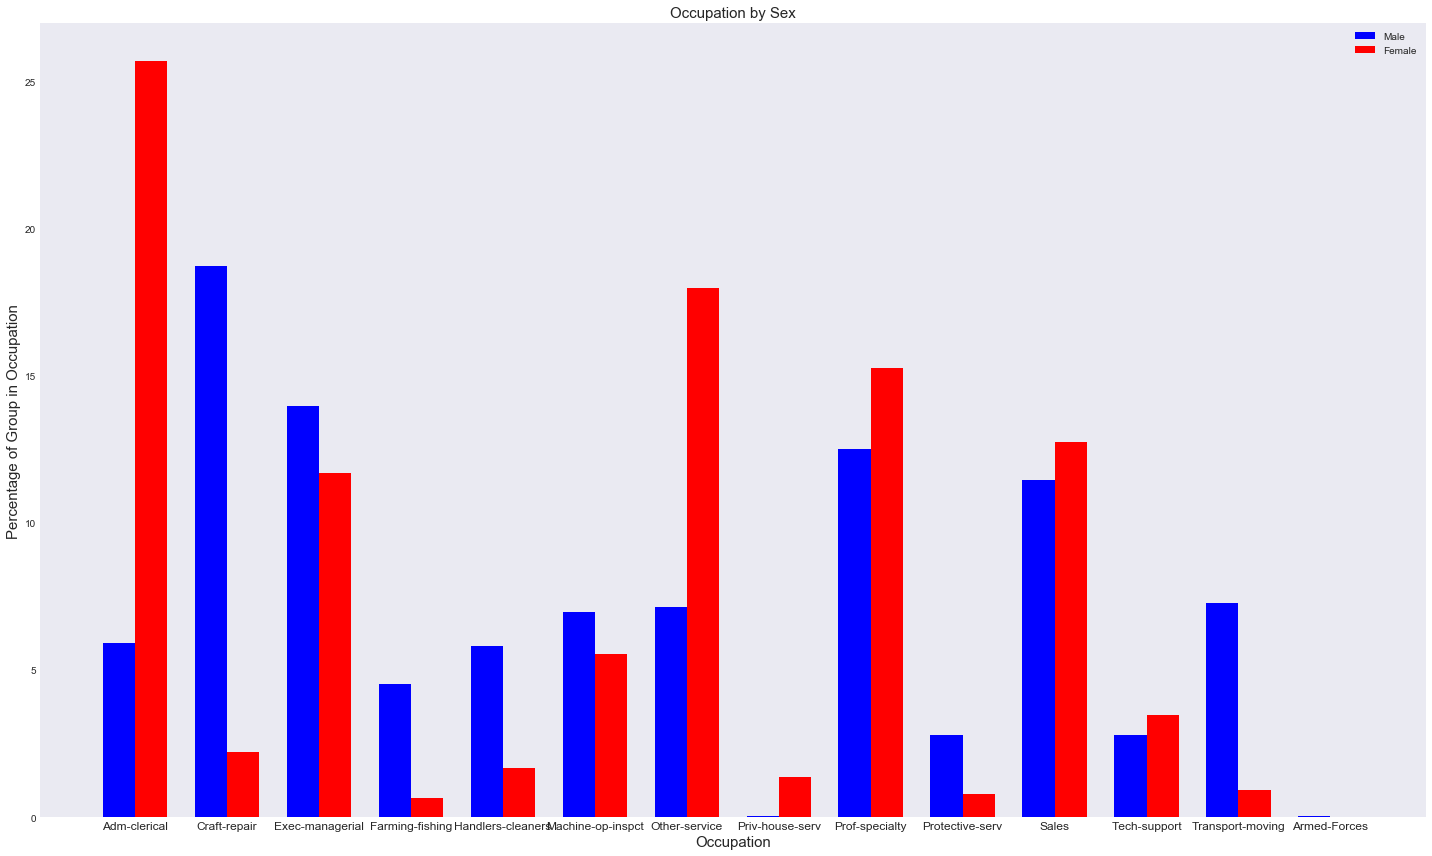

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=1)

bar_width = 0.35

counts = male["occupation"].value_counts().sort_index()
#Drop Armed Forces and append to end so that occupations match
armed_forces = counts["Armed-Forces"]
male_counts = counts.drop("Armed-Forces")
male_counts["Armed-Forces"] = armed_forces
male_percents = 100 * male_counts.values/male_counts.values.sum()
ind = np.arange(len(male_percents))
p1 = ax.bar(ind, male_percents, bar_width, color = "blue")

female_counts = female["occupation"].value_counts().sort_index()
female_counts["Armed-Forces"] = 0
female_percents = 100 * female_counts.values/female_counts.values.sum()
ind = np.arange(len(female_percents))
p2 = ax.bar(ind + bar_width, female_percents, bar_width, color = "red")

ax.set_title("Occupation by Sex", fontsize = 15)
ax.set_ylabel("Percentage of Group in Occupation", fontsize = 15)
ax.set_xlabel("Occupation", fontsize = 15)
plt.xticks(ind + bar_width/2, female_counts.index, fontsize = 12)

plt.legend((p1[0], p2[0]), ('Male', 'Female'))
plt.tight_layout()
plt.savefig("fig/occupation_by_sex.png")

It seems like females are more likely to be in Administrative clerical roles and other services not explictly stated, while males are more likely to be in craft repair, handling/cleaning, farming/fishing, and transport. There does seem to be a difference in executive managerial roles, but it does not seem like the difference is huge. 

What about for race? (Unfortunately it is very hard to make one bar chart to show all the races, so we decided to instead to just make one bar chart for each race. We must be cautious to not compare the different plots because the y-scale is different.)

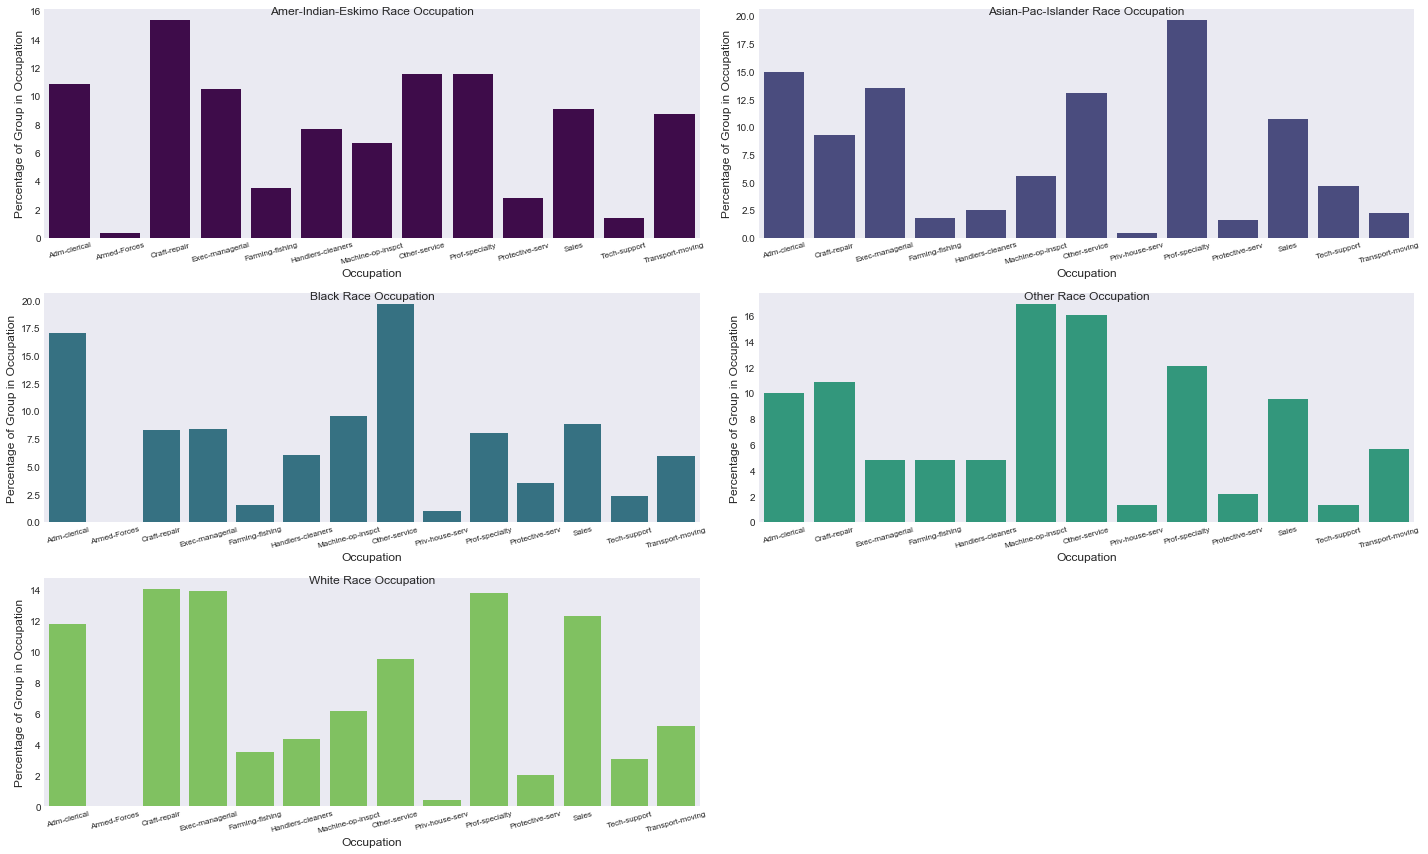

In [6]:
race_groups = clean_adult.groupby("race")
nrows = round((len(race_groups) + 0.0001)/2)
fig, axes = plt.subplots(nrows=nrows, ncols=2)
row = 0
column = 0
bar_width = 0.35
cmap = cm.get_cmap('viridis')

i = 0
for name, group in race_groups:
    if nrows > 1:
        ax = axes[row, column]
    else:
        ax = axes[column]
    counts = group["occupation"].value_counts().sort_index()
    percents = 100 * counts.values/counts.values.sum()
    ind = np.arange(len(percents))
    p = sns.barplot(ind, percents, ax =ax, color = cmap(i))
    ax.set_title("Occupation by Sex", fontsize = 15)
    ax.set_ylabel("Percentage of Group in Occupation", fontsize = 12)
    ax.set_xlabel("Occupation", fontsize = 12)
    ax.set_xticklabels(counts.index, fontsize = 8, rotation = 15)
    ax.set_title("".join(name) + " Race Occupation", y = 0.95, fontsize=12)

    #if column = 0, then it is next 1. If column = 1, then it is next 0
    column = 1 - column
    #move on to next row
    if column == 0:
        row += 1
    i += 0.2
#if odd number of plots, hide last axis
if column == 1:
    axes[-1, -1].axis("off")
plt.tight_layout()
plt.savefig("fig/occupation_by_race")

There seems to be a difference in each race's distribution of occupations. Some observations are:
* Around 15% of the individuals identified as White and Asian/Pacific Islander have executive/managerial roles, while the other groups have lower. This is probably reflective of the fact that these groups have more opportunities than the other groups, or it could reflect an inherent bias of society. A more detailed study needs to be done to make an judgement about this observation.
* The most common occupation for the Asian/Pacific Islander group is Prof-specialty. This can be reflective of the fact that immigrants from this group tend to already have obtained a higher education when immigrating and that the culture values education.
* The armed forced occupation has a very small sample. This is most likely because it does not really count as an occupation and there are a few exceptions. 



Small side note: While doing this project, we found an interesting property regarding the `round()` function, in which by default this function actually rounds half numbers to the nearest even number. This is called bankers rounding: https://stackoverflow.com/questions/33019698/how-to-properly-round-up-half-float-numbers-in-python. We found this out when we were not getting the correct number of rows for our subplots.


Now that we saw all the "pretty" graphs, let's do some hypothesis testing. We are interested in using the Chi-Square Test of Independence, which is used to determine whether there is an association between two categorical variables. The test procedure is appropriate when the following conditions are met:
* The sampling method is simple random sampling.
* The variables under study are each categorical.
* If sample data are displayed in a contingency table, the expected frequency count for each cell of the table is at least 5. 

The last condition poses a problem, as there are some occupations in which there is a group that has no members in the occupation. Thus, we will have to proceed with caution. However, we also believe at the same time that if the expected frequency count for a cell is less than 5, then there is an obvious relationship between the categorical variables. We are interested in the pairwise group relationships (i.e. white/black, white/asian. etc.), so we will run chi-square for each pair in a group.

Of course, we cannot say that there is any causal relationship between groups and occupations, as there are many other confounding variables such as education.

In [7]:
# %load find_indices_with_value.py
def find_indices_with_value(df, value):
    """Return the row indices of a Pandas Dataframe where the row contains the given value.
    
    Parameters
    ----------
    
    df: Pandas Dataframe
    value: value we want to see if row contains
    
    Return
    ------
    array
        An integer array where each value is the row index of a row that contains the value
        
    Example
    -------
    
    >>> row0 = [">", "?", "!"]
    ... df = pd.DataFrame([row0])
    ... find_indices_with_value(df, "?")
    array([0])
    """
    
    rows = []
    for index, row in df.iterrows():
        if value in row.unique():
            rows.append(index)
    return np.array(rows) 

In [8]:
def chi_square_test(data, var1, var2, pairwise = False, alpha = 0.05):
    """Performs a chi-square test on two categorical variables, with one being group 
    If doing pairwise comparisions for groups, perform chi-square test on each pair. 
    Displays contigency tables (in percents) that are statistically significant. 
    If there are rows in the contigency with 0s, we delete these rows. 
    
    Parameters
    ----------
    data: Pandas Dataframe
    var1: one categorical column of the data Dataframe
    var2: one categorical column of the data Dataframe. In our case this will be the group column.
    pairwise: if true, do pairwise comparisions.
    alpha: significance level
    
    Return
    ------
    if pairwise: 
        None
    else:
        rtn 
           A tuple where 
           the first value is the chi-square value
           the second value is the p-value
           the third value is the degrees of freedom
           the fourth value is the expected counts 
        
    """    
    cont_table = pd.crosstab(data[var1], data[var2])
    if not pairwise:
        missing_indices = find_indices_with_value(cont_table, 0)
        cont_table = cont_table.drop(missing_indices)
        chi2, p, df, exp = stats.chi2_contingency(cont_table)
        if (p < alpha): 
            print("statistically significant: %s" % (tuple([var1, var2]), ))
            print("p-value is " + str(p))
            display(cont_table.apply(lambda r: 100 * r/r.sum(), axis=0))

        return chi2, p, df, exp
    else:
        pairs = [",".join(map(str, comb)).split(",") for comb in combinations(cont_table.columns, 2)]
        for pair in pairs:
            cont_table2 = cont_table[pair]
            missing_indices = find_indices_with_value(cont_table2, 0)
            cont_table2 = cont_table2.drop(missing_indices)
        
            chi2, p, df, exp = stats.chi2_contingency(cont_table2)
            if (p < alpha): 
                print("statistically significant: %s" % (tuple(pair), ))
                print("p-value is " + str(p))
                display(cont_table2.apply(lambda r: 100 * r/r.sum(), axis=0))            

Let's first look at the relationship between occupation and sex. Note that we cannot make any huge conclusions from this since 85% of the individuals in the dataset are White, so sample size for other races are small (but still greater than 30). 

In [9]:
chi_square_test(clean_adult, "occupation", "sex");

statistically significant: ('occupation', 'sex')
p-value is 0.0


sex,Female,Male
occupation,,
Adm-clerical,25.679820,5.934907
Craft-repair,2.208137,18.722694
Exec-managerial,11.684727,13.985568
Farming-fishing,0.664486,4.535860
Handlers-cleaners,1.676549,5.822002
Machine-op-inspct,5.551012,6.985420
Other-service,17.971785,7.137598
Priv-house-serv,1.380086,0.039272
Prof-specialty,15.242282,12.503068


There is a clear association between sex and occupation. As mentioned before, it seems like females are more likely to be in Administrative clerical and other services not explicitly stated, while males are more likely to be in craft repair, handling/cleaning, farming/fishing, and transport. There does seem to be a difference in executive managerial roles, but it does not seem like the difference is huge. 

What about for race?

In [10]:
chi_square_test(clean_adult, "occupation", "race", True);

statistically significant: ('Amer-Indian-Eskimo', 'Asian-Pac-Islander')
p-value is 5.39804424413e-11


race,Amer-Indian-Eskimo,Asian-Pac-Islander
occupation,,
Adm-clerical,10.877193,15.039282
Craft-repair,15.438596,9.315376
Exec-managerial,10.526316,13.580247
Farming-fishing,3.508772,1.795735
Handlers-cleaners,7.719298,2.469136
Machine-op-inspct,6.666667,5.611672
Other-service,11.578947,13.131313
Prof-specialty,11.578947,19.753086
Protective-serv,2.807018,1.571268


statistically significant: ('Amer-Indian-Eskimo', 'Black')
p-value is 4.29464358621e-07


race,Amer-Indian-Eskimo,Black
occupation,,
Adm-clerical,10.839161,17.204301
Armed-Forces,0.349650,0.035842
Craft-repair,15.384615,8.387097
Exec-managerial,10.489510,8.422939
Farming-fishing,3.496503,1.505376
Handlers-cleaners,7.692308,6.093190
Machine-op-inspct,6.643357,9.641577
Other-service,11.538462,19.820789
Prof-specialty,11.538462,8.100358


statistically significant: ('Amer-Indian-Eskimo', 'Other')
p-value is 0.00793749750909


race,Amer-Indian-Eskimo,Other
occupation,,
Adm-clerical,10.877193,10.087719
Craft-repair,15.438596,10.964912
Exec-managerial,10.526316,4.824561
Farming-fishing,3.508772,4.824561
Handlers-cleaners,7.719298,4.824561
Machine-op-inspct,6.666667,17.105263
Other-service,11.578947,16.228070
Prof-specialty,11.578947,12.280702
Protective-serv,2.807018,2.192982


statistically significant: ('Amer-Indian-Eskimo', 'White')
p-value is 0.000523857680953


race,Amer-Indian-Eskimo,White
occupation,,
Adm-clerical,10.839161,11.822336
Armed-Forces,0.349650,0.027107
Craft-repair,15.384615,14.110905
Exec-managerial,10.489510,13.921159
Farming-fishing,3.496503,3.523854
Handlers-cleaners,7.692308,4.356413
Machine-op-inspct,6.643357,6.153191
Other-service,11.538462,9.572491
Prof-specialty,11.538462,13.843711


statistically significant: ('Asian-Pac-Islander', 'Black')
p-value is 2.08005869185e-35


race,Asian-Pac-Islander,Black
occupation,,
Adm-clerical,14.972067,17.045455
Craft-repair,9.273743,8.309659
Exec-managerial,13.519553,8.345170
Farming-fishing,1.787709,1.491477
Handlers-cleaners,2.458101,6.036932
Machine-op-inspct,5.586592,9.552557
Other-service,13.072626,19.637784
Priv-house-serv,0.446927,0.958807
Prof-specialty,19.664804,8.025568


statistically significant: ('Asian-Pac-Islander', 'Other')
p-value is 1.10595148479e-11


race,Asian-Pac-Islander,Other
occupation,,
Adm-clerical,14.972067,9.956710
Craft-repair,9.273743,10.822511
Exec-managerial,13.519553,4.761905
Farming-fishing,1.787709,4.761905
Handlers-cleaners,2.458101,4.761905
Machine-op-inspct,5.586592,16.883117
Other-service,13.072626,16.017316
Priv-house-serv,0.446927,1.298701
Prof-specialty,19.664804,12.121212


statistically significant: ('Asian-Pac-Islander', 'White')
p-value is 7.82321814761e-15


race,Asian-Pac-Islander,White
occupation,,
Adm-clerical,14.972067,11.775823
Craft-repair,9.273743,14.055388
Exec-managerial,13.519553,13.866389
Farming-fishing,1.787709,3.509990
Handlers-cleaners,2.458101,4.339273
Machine-op-inspct,5.586592,6.128982
Other-service,13.072626,9.534830
Priv-house-serv,0.446927,0.420427
Prof-specialty,19.664804,13.789246


statistically significant: ('Black', 'Other')
p-value is 1.08587334985e-05


race,Black,Other
occupation,,
Adm-clerical,17.045455,9.956710
Craft-repair,8.309659,10.822511
Exec-managerial,8.345170,4.761905
Farming-fishing,1.491477,4.761905
Handlers-cleaners,6.036932,4.761905
Machine-op-inspct,9.552557,16.883117
Other-service,19.637784,16.017316
Priv-house-serv,0.958807,1.298701
Prof-specialty,8.025568,12.121212


statistically significant: ('Black', 'White')
p-value is 1.10592086605e-131


race,Black,White
occupation,,
Adm-clerical,17.039404,11.772645
Armed-Forces,0.035499,0.026993
Craft-repair,8.306709,14.051594
Exec-managerial,8.342208,13.862646
Farming-fishing,1.490948,3.509043
Handlers-cleaners,6.034789,4.338102
Machine-op-inspct,9.549166,6.127328
Other-service,19.630813,9.532256
Priv-house-serv,0.958466,0.420314


statistically significant: ('Other', 'White')
p-value is 8.67474040807e-12


race,Other,White
occupation,,
Adm-clerical,9.956710,11.775823
Craft-repair,10.822511,14.055388
Exec-managerial,4.761905,13.866389
Farming-fishing,4.761905,3.509990
Handlers-cleaners,4.761905,4.339273
Machine-op-inspct,16.883117,6.128982
Other-service,16.017316,9.534830
Priv-house-serv,1.298701,0.420427
Prof-specialty,12.121212,13.789246


Wow! All races are statistically different from each other in occupation. 

Let's also look at the relationship between sex and race. Since our dataset is composed of people in the labor force, this will answer whether different races have different proportions of sexes participating in the labor force.

In [11]:
chi_square_test(clean_adult, "sex", "race", True);

statistically significant: ('Amer-Indian-Eskimo', 'Black')
p-value is 0.000101308693717


race,Amer-Indian-Eskimo,Black
sex,,
Female,37.412587,49.662762
Male,62.587413,50.337238


statistically significant: ('Amer-Indian-Eskimo', 'White')
p-value is 0.0131118233873


race,Amer-Indian-Eskimo,White
sex,,
Female,37.412587,30.443836
Male,62.587413,69.556164


statistically significant: ('Asian-Pac-Islander', 'Black')
p-value is 1.96539129404e-18


race,Asian-Pac-Islander,Black
sex,,
Female,32.849162,49.662762
Male,67.150838,50.337238


statistically significant: ('Black', 'Other')
p-value is 0.000582810354601


race,Black,Other
sex,,
Female,49.662762,37.662338
Male,50.337238,62.337662


statistically significant: ('Black', 'White')
p-value is 4.11990122916e-95


race,Black,White
sex,,
Female,49.662762,30.443836
Male,50.337238,69.556164


statistically significant: ('Other', 'White')
p-value is 0.0214225449555


race,Other,White
sex,,
Female,37.662338,30.443836
Male,62.337662,69.556164


The Black population seems to differ significantly from the other race populations, which is not surprising, since they have a 50/50 male to female labor participation, while other races seem to be around 60/40 or 70/30.

Finally, since we mentioned before that education might be a confounding variable, let's see if there is a relationship between occupation and education.

In [12]:
chi_square_test(clean_adult,"occupation", "education");

statistically significant: ('occupation', 'education')
p-value is 0.0


education,10th,11th,12th,1st-4th,5th-6th,7th-8th,9th,Assoc-acdm,Assoc-voc,Bachelors,Doctorate,HS-grad,Masters,Preschool,Prof-school,Some-college
occupation,,,,,,,,,,,,,,,,
Craft-repair,75.813953,75.217391,68.75,51.111111,52.564103,59.042553,75.000000,43.181818,52.765957,12.514221,0.655738,75.128306,2.470588,28.571429,1.541850,58.799172
Farming-fishing,20.000000,16.086957,20.00,40.000000,46.153846,36.702128,22.580645,5.303030,11.063830,4.379977,0.327869,15.831030,1.176471,64.285714,0.881057,12.008282
Prof-specialty,4.186047,8.695652,11.25,8.888889,1.282051,4.255319,2.419355,51.515152,36.170213,83.105802,99.016393,9.040663,96.352941,7.142857,97.577093,29.192547


Just as expected!

Thus, we saw that there is a statistically significant relationship between sex and occupation and also between race and occupation, but we cannot any causal relationship since education is a confounding variable. 

** Obsolete Pie Charts**

In the beginning, we decided to visualize using pie charts. However, we have been told to never use pie charts, as they are pretty misleading: While they are aesthetically pleasing (debatable), it is hard to make comparisons because of the proportions and angles. Here is an article detailing why pie charts are bad: http://www.businessinsider.com/pie-charts-are-the-worst-2013-6

However, we did not just want to delete all this code and pretend we never attempted to make pie charts, so here is all the code that is no longer part of our analysis. This also serves as a sanity check for our bar charts.

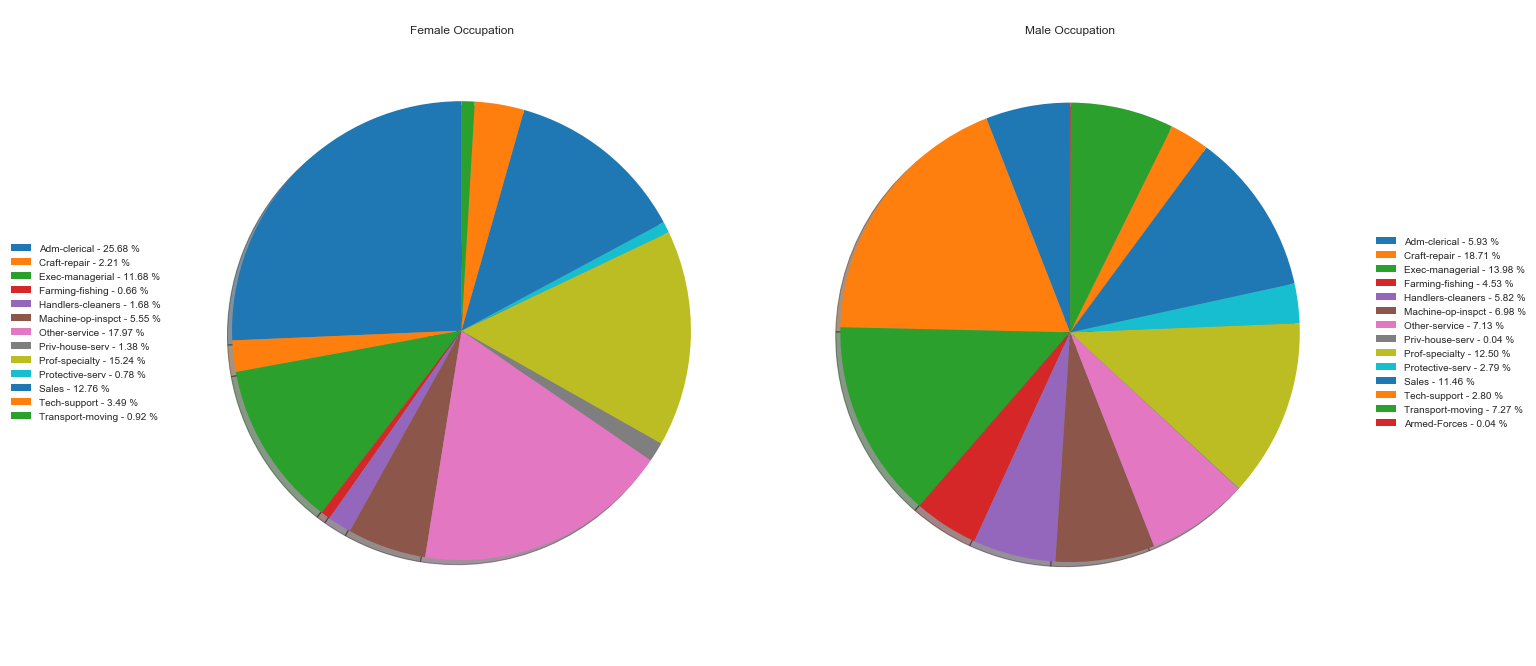

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=2)
ax1 = axes[0]
counts = female["occupation"].value_counts().sort_index()
percents = 100 * counts.values/counts.values.sum()
patches, texts = ax1.pie(percents, shadow=True, startangle=90)
ax1.axis("equal")
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(counts.index, percents)]
ax1.legend(patches, labels, loc="center", bbox_to_anchor=(-0.24, 0.5),
           fontsize=10)
ax1.set_title("Female Occupation", y = 0.95)

ax2 = axes[1]
counts = male["occupation"].value_counts().sort_index()
#Drop Armed Forces and append to end so that occupations match
armed_forces = counts["Armed-Forces"]
counts = counts.drop("Armed-Forces")
counts["Armed-Forces"] = armed_forces
percents = 100 * counts.values/counts.values.sum()
patches, texts = ax2.pie(percents, shadow=True, startangle=90)
ax2.axis("equal")
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(counts.index, percents)]
ax2.legend(patches, labels, loc="center", bbox_to_anchor=(1.25, 0.5),
           fontsize=10)
ax2.set_title("Male Occupation", y = 0.95);

In [14]:
def plot_pie(data, groupby_columns, plot_column):
    groups = data.groupby(groupby_columns)
    nrows = round((len(groups) + 0.0001)/2)
    fig, axes = plt.subplots(nrows=nrows, ncols=2)
    row = 0
    column = 0
    unique_values = data[plot_column].unique()
    #Get all values which not all groups contain
    s = set()
    for name, group in groups:
        for value in unique_values:        
            if value not in group[plot_column].unique():
                s.add(value)
    for name, group in groups:
        if nrows > 1:
            ax = axes[row, column]
        else:
            ax = axes[column]
        counts = group[plot_column].value_counts().sort_index()
        for value in s:
        #Drop values which not all groups contain and append to end so that occupations match
            if value in counts.index:
                dropped_value = counts[value]
                counts = counts.drop(value)
                counts[value] = dropped_value
        percents = 100 * counts.values/counts.values.sum()
        patches, texts = ax.pie(percents, shadow=True, startangle=90)
        ax.axis("equal")
        labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(counts.index, percents)]
        if column == 0:
            ax.legend(patches, labels, loc="center", bbox_to_anchor=(-0.4, 0.5), ncol = 2,
                       fontsize=13)
        else:
            ax.legend(patches, labels, loc="center", bbox_to_anchor=(1.4, 0.5), ncol = 2,
                       fontsize=13)        
        ax.set_title("".join(name) + " " + plot_column, y = 0.95, fontsize=15)

        #if column = 0, then it is next 1. If column = 1, then it is next 0
        column = 1 - column
        #move on to next row
        if column == 0:
            row += 1
    #if odd number of plots, hide last axis
    if column == 1:
        axes[-1, -1].axis("off")
#     fig.savefig("fig/" + plot_column + "_by_" + "".join(groupby_columns) + ".png", bbox_inches='tight')


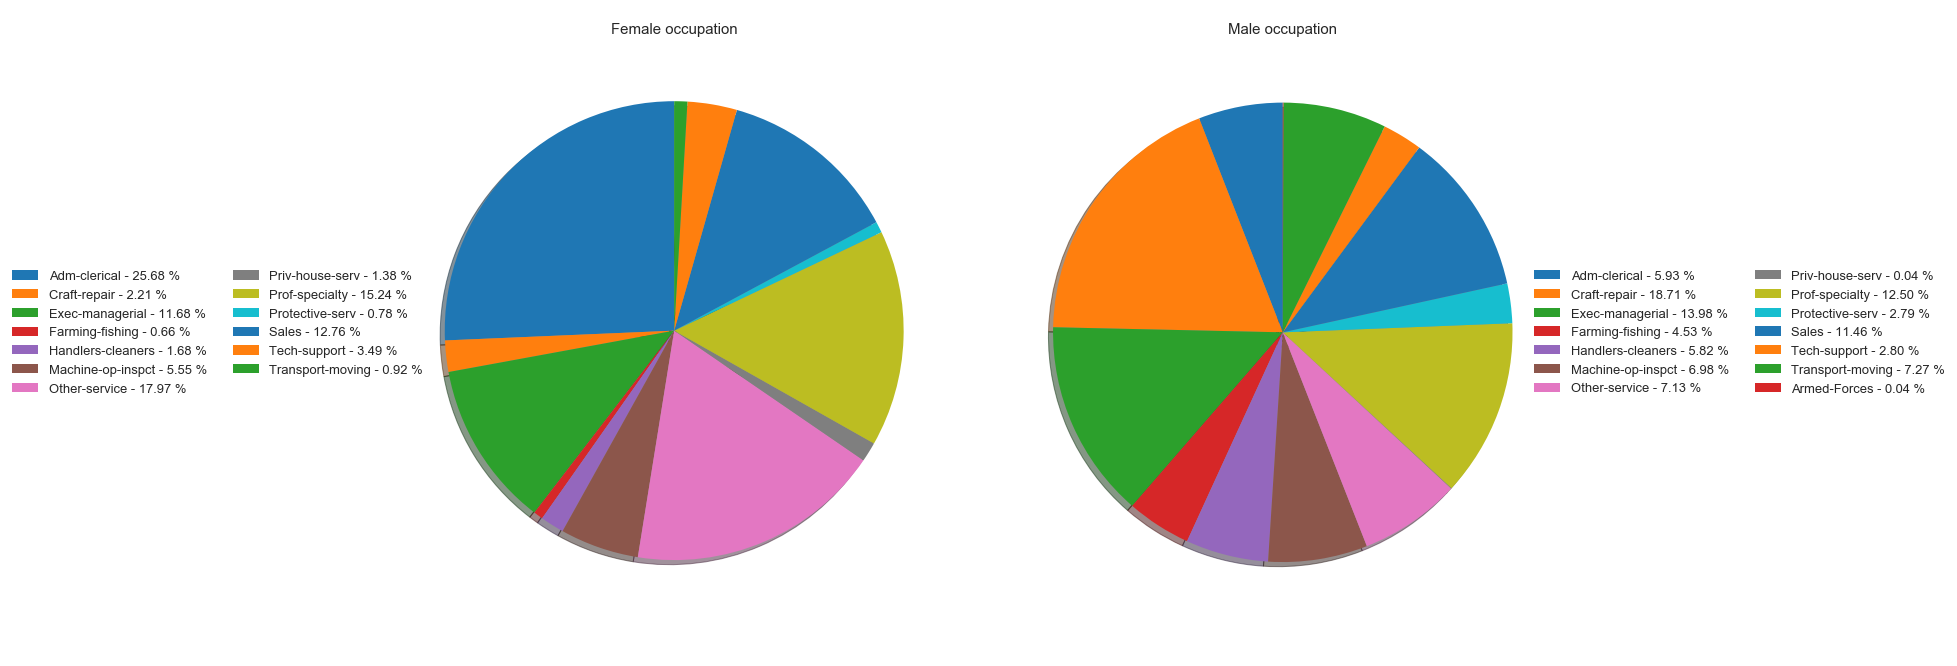

In [15]:
plot_pie(clean_adult, "sex", "occupation") #Same as above

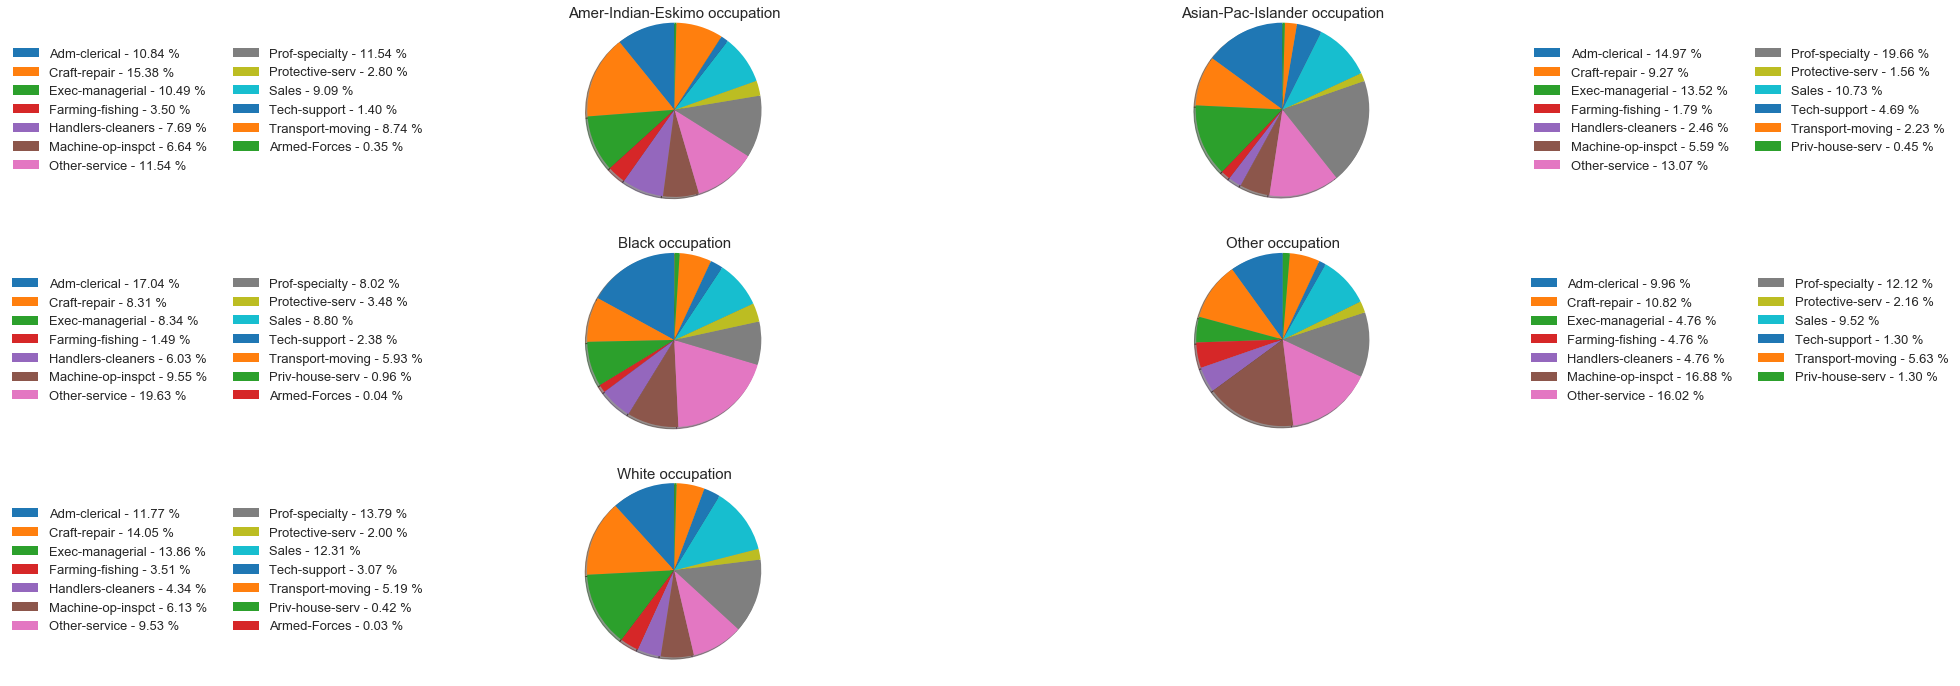

In [16]:
plot_pie(clean_adult, "race", "occupation")

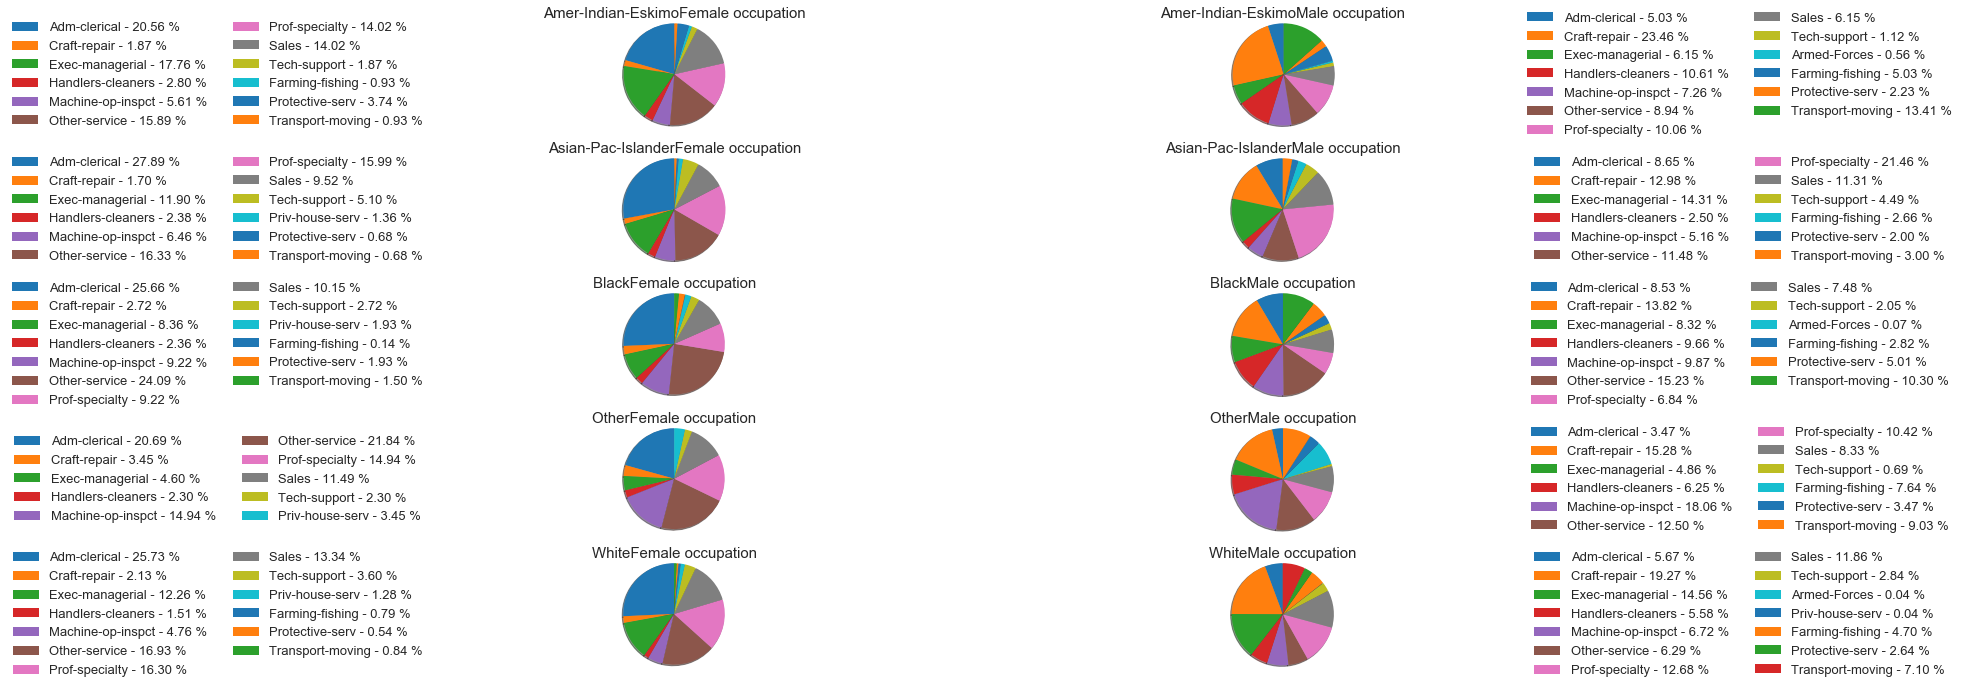

In [17]:
plot_pie(clean_adult, ["race", "sex"], "occupation")